# RNN training tutorial

This is a tutorial training various RNNs on simple datasets and doing some analysis.

Structure:

  1. basic (vanilla RNN) implementation
  2. observing exploding/vanishing gradients
  3. Intepretability by plotting and analysing activations of a network:
    * identifying interpretable neurons
    * identifying neurons-gates interactions
    * identifying hidden state dynamics through time
  4. training an LSTM on character level langugage modelling task
    * comparing training of an LSTM and RNN, playing with architectures
    

First three sections are almost independent, one can go switch between them without any code dependencies (apart from being unable to use vanilla RNN in section 4, if it was not implemented in 1.).

Cells that include "starting point" in their title require filling in some code gaps; all remaining ones are complete (but feel free to play with them if you want!)

Please pay attention to questions after each section. Finding out answers to these is crucial to make sure one understands various modes of RNN operation.

In [0]:
#@title Installing Sonnet
!pip install -q dm-sonnet

## Imports

We will use Sonnet.

In [0]:
#@title imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import numpy as np
import seaborn as sns
import sonnet as snt
import tensorflow as tf

from matplotlib import pyplot as plt

from sonnet.examples import dataset_shakespeare
  
sns.set_style('ticks')  

# Ex 1.    Vanilla RNN

Implement basic RNN cell in sonnet.

   $$ h_t = f( Wx_t + Vh_{t-1}  + b) $$
   
   Where
   
   * $x_t$ input at time $t$
   * $h_t$ hidden state at time $t$
   * $W$ input-to-hidden mapping (trainable)
   * $V$ hidden-to-hidden mapping (trainable)
   * $b$ bias (trainable)
   * $f$ non-linearity chosen (usually tanh)
   
   
   You do not need to worry about the plotting and running code, but focus on the RNN implementation.

In [0]:
?snt.Linear

In [0]:
#@title Vanilla RNN - Starting point
class RNN(snt.RNNCore):
  
  def __init__(self, hidden_size, activation=tf.tanh, name="vanilla_rnn"):    
    """
    Args:
    
      hidden_size: number of hidden units
      activation: function constructing activation op
      name: name of the core
    """    
    # We have to call parent's constructor with the name provided
    super(RNN, self).__init__(name=name)
    
    self.hidden_size = hidden_size
    self._hidden_size = hidden_size

    self.activation = activation
    self.name = name
    self.inp_trans = snt.Linear(hidden_size)
    self.h_trans = snt.Linear(hidden_size)
  

  def _build(self, input_, prev_state):
    """
    This function will be called in a loop, when RNN core is connected to
    ops creating inputs and previous states.
    
    Args:
    
      input_: tensor containing current x_t
      prev_state: tensor containing previous state, h_{t-1}
    """
    xi = self.inp_trans(input_)
    xh = self.h_trans(prev_state)
    output = self.activation(xi + xh)
    ################
    #   YOUR CODE  #
    ################
    
    # Cores in sonnet return pairs of (o_t, h_t) where o_t is the output
    # exposed to the rest of the code, for Vanilla RNN these are the same
    # quantities
    return output, output
  
  @property
  def state_size(self):
    return tf.TensorShape([self._hidden_size])

  @property
  def output_size(self):
    return tf.TensorShape([self._hidden_size])

### Train the RNN

Train the RNN on sine data - predict the next sine value from predicted sine values.

Predict   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

To learn the prediction model, we will use *teacher forcing*. This means that when training the model, the input at time $t$ is the real sequence at time $t$, rather than the output produced by the model at $t-1$. When we want to generate data from the model, we do not have access to the true sequence, so we do not use teacher forcing. However, in the case of our problem, we will also use *warm starting*, because we require multiple time steps to predict the next sine wave value (at least 2, for the initial value and for the step). 

The code below unrolls the RNN core you have defined above, does the training using backprop though time and plots the real data ("ground truth"), the data generated during training ("train predictions") and the model samples "generated".


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


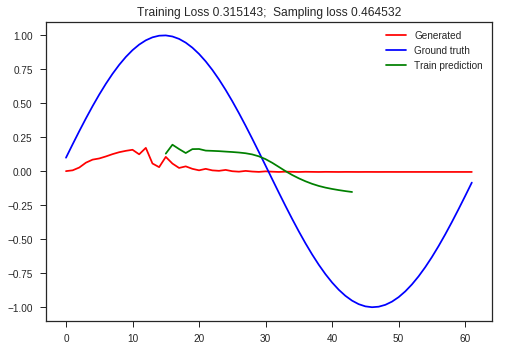

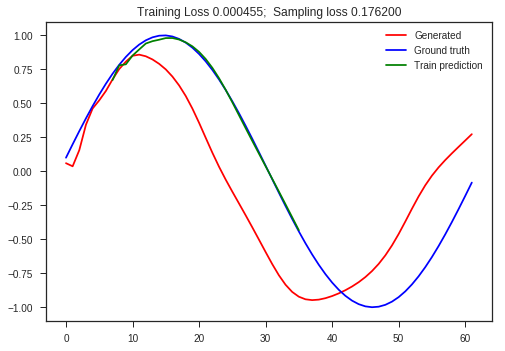

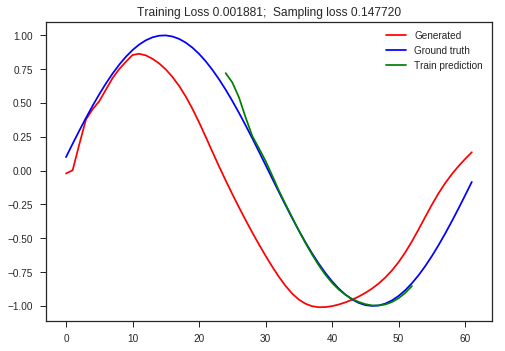

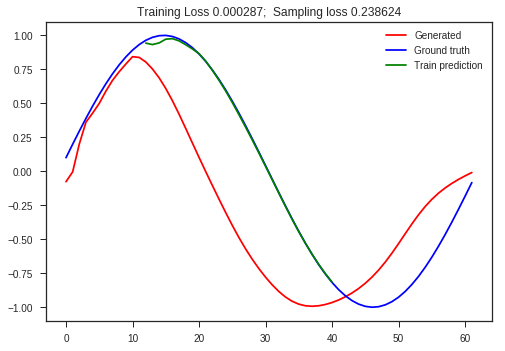

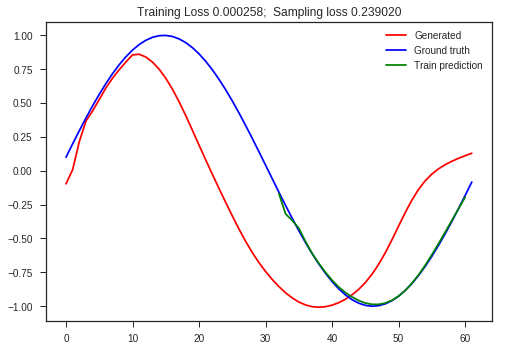

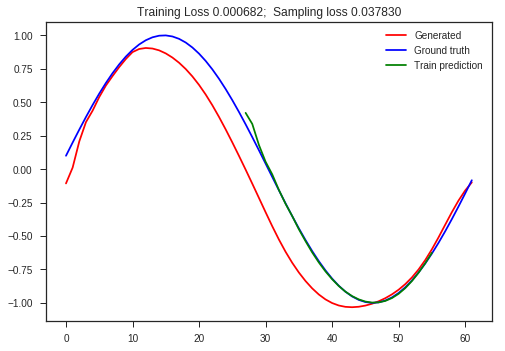

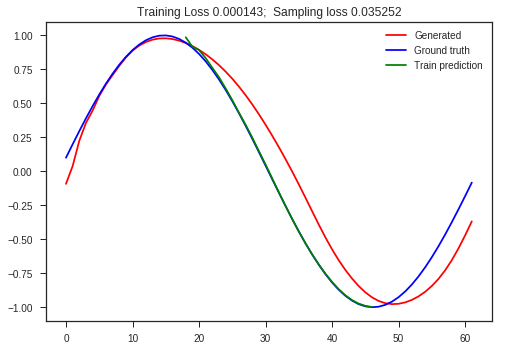

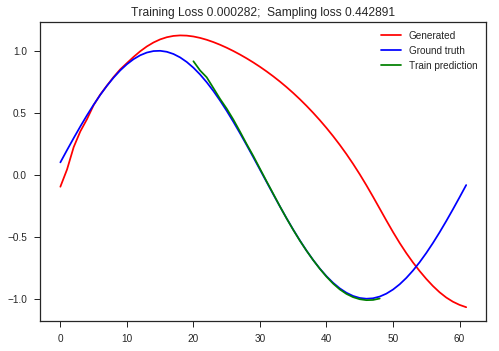

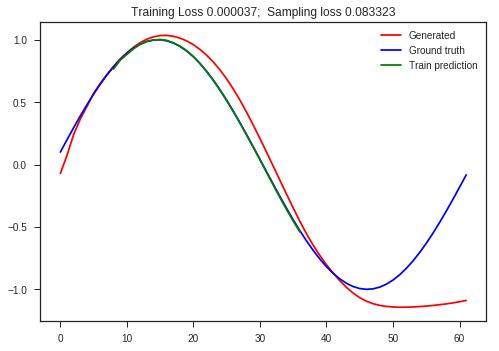

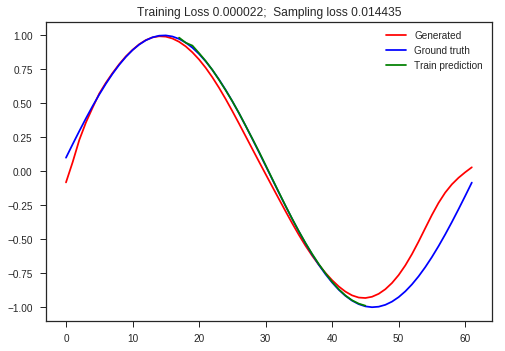

In [42]:
#@title Training a simple sequence, using teacher forcing and sampling

UNROLL_LENGTH = 30 #@param
NUM_ITERATIONS = 10000#@param
WARM_START = 10#@param
TEACHER_FORCING = True#@param
HIDDEN_UNITS = 20 #@param
LEARNING_RATE = 0.0005 #@param
REPORTING_INTERVAL = 1000 #@param

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

tf.reset_default_graph()

# Creating two sonnet modules, one - an RNN we defined in the previous cell
# and the second - a linear mapping from RNN output to the target - scalar
rnn = RNN(HIDDEN_UNITS)
dec = snt.Linear(1)

# Placeholder is gonna be used to provide a subsequence on which we will learn
# Each subsequence will be a consequitive block of UNROLL_LENGTH values of
# the sine wave
sequence = tf.placeholder(tf.float32, [UNROLL_LENGTH, 1, 1])


# First, the training section

losses = []
train_predictions = []
current_state = rnn.initial_state(1)

# For simplicity, we will unroll our RNN by hand in a loop
for i in range(UNROLL_LENGTH-1):
  
  # In teacher forcing setup, input is the true previous output
  if TEACHER_FORCING:
    input_ = sequence[i]
  else:
    # In "generative" mode the input is our own previous prediction
    if i <= WARM_START:
      # We can still use teacher forcing at the very beginning of trianing
      input_ = sequence[i]
    else:
      input_ = prediction
      
  # Connecting an RNN, we apply our cell to (input, state) pair, and we get
  # (output, next_state) pair in return
  output, current_state = rnn(input_, current_state)
  
  prediction = dec(output)
  losses.append(tf.reduce_sum((prediction - sequence[i+1])**2))
  train_predictions.append(prediction)

loss = tf.add_n(losses) / len(losses)
train_predictions = tf.stack(train_predictions)
  
opt = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = opt.minimize(loss)


# Now we define a part of the graph used for generating data
# The code is almost the same as the training one, with the only difference
# being that now we unroll over entire signal, and use our own predictions
# to condition ourselves.

current_state = rnn.initial_state(1)
predictions = []
sampling_losses = []
for i in range(len(y_train)-1):
  if i <= WARM_START:
    input_ = tf.constant(y_train[i], dtype=tf.float32)
  else:
    input_ = prediction
  output, current_state = rnn(input_, current_state)
  prediction = dec(output)
  sampling_losses.append(tf.reduce_sum((prediction - y_train[i+1])**2))
  predictions.append(prediction)
sampling_loss = tf.add_n(sampling_losses) / len(sampling_losses)
predictions = tf.stack(predictions)


# At this point entire graph is built, and we can create the session and run

with tf.train.MonitoredSession() as sess:
  for i in range(NUM_ITERATIONS):
    start = np.random.choice(
      range(x_train.shape[0] - UNROLL_LENGTH)
    )
    l, p, _ = sess.run([loss, train_predictions, train_op], 
                    feed_dict={sequence: y_train[start: start+UNROLL_LENGTH]})
    
    if i % REPORTING_INTERVAL == 0:
      pred, pred_l = sess.run([predictions, sampling_loss])
      plt.figure()
      plt.title('Training Loss %f;  Sampling loss %f' % (l, pred_l))
      plt.plot(pred.ravel(), c='r', label='Generated')
      plt.plot(y_train[1:].ravel(), c='b', label='Ground truth')
      plt.plot(range(start, start+UNROLL_LENGTH-1), p.ravel(), c='g',
               label='Train prediction')
      plt.legend()
      plt.show()

###What is worth trying/understanding here?

* Difference between teacher forcing and learning on own samples
 * What is teacher forcing really learning?
 * Why is the model struggling to learn in one of the setups?
 * What is it we actually care about for models like this? What should be the actual surrogate?
* How does warm starting affect our training? Why?
* What happens if the structure of interest is much longer than the unroll length?

# Ex. 2      Vanishing and exploding gradients

Given a sequence $(x_1, ..., x_N)$ of random floats (sampled from normal distribution), compute:
$$
\left \| \frac{\partial h_{N}}{\partial h_i} \right \|
$$
for each $i$, and plot these quantities for various RNNs.

Note, that during learning one would compute
$$
\frac{\partial L}{\partial \theta}  
$$
which, using chain rule will involve terms like
$$
\frac{\partial L}{\partial h_N} \cdot
\frac{\partial h_N}{\partial h_i} \cdot
\frac{\partial h_i}{\partial \theta}
$$
so if one of them vanishes, all of them do.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


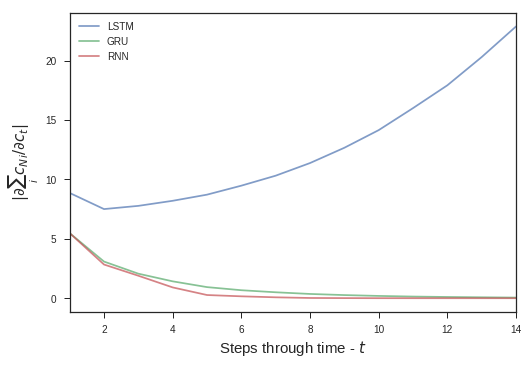

In [7]:
#@title Vanishing and exploding gradients - Starting point
tf.reset_default_graph()

SEQ_LENGTH = 15 #@param
HIDDEN_UNITS = 30 #@param

# We are gonna use completely random signal as input
dummy_input = [tf.constant([[np.random.normal()]]) for _ in range(SEQ_LENGTH)] 

rnn_types = {
    'LSTM': (lambda x: snt.LSTM(x, forget_bias=10), lambda x: x.cell),
    'RNN': (RNN, lambda x: x),
    'GRU' : (lambda x: snt.GRU(x), lambda x: x.cell)

    # Add more cores here, by playing with forget_bias and initializers
    # of LSTMs, can you create a core which is initialised to having
    # forget_gate always open (no forgetting) and input gate closed
    # (no dependence on input)?
    
    ##########################
    #  (OPTIONAL) YOUR CODE  #
    ##########################
}

depths = {rnn_type: [] for rnn_type in rnn_types}
grad_norms = {rnn_type: [] for rnn_type in rnn_types}

# Iterate over all RNNs we want to analyse
for rnn_type in rnn_types:
  
  # Each entry is a pair (constructor, extractor)
  constructor, extractor = rnn_types[rnn_type]
  
  # extractor is a function that will return vector of interest when applied to state
  
  rnn = constructor(HIDDEN_UNITS)

  rnn_at_time = []
  gradients_at_time = []

  # We need to manually unroll our RNNs such that they populate:
  #  rnn_at_time[t] - extractor applied to state at time t
  
  ################
  #   YOUR CODE  #
  ################
  prev_state = rnn.initial_state(1)
  for i in range(0, SEQ_LENGTH):
    out, prev_state = rnn(dummy_input[i], prev_state)
    rnn_at_time.append(prev_state)
    
  
  # Dummy loss is just a sum of activations, as we are not training anything
  # and just need an anchor for partial derivatives computation
  dummy_loss = tf.reduce_sum(rnn_at_time[-1])
  
  # We use tf.gradients to compute partial derivatives of interest
  for i in range(1, SEQ_LENGTH):
    current_gradient = tf.gradients(
      dummy_loss, 
      rnn_at_time[i],   
    )
    gradients_at_time.append(current_gradient)
  
  # Finally, compute actual gradients by calling our tf.gradients ops
  init = tf.global_variables_initializer()  
  with tf.train.SingularMonitoredSession() as sess:
    sess.run(init)
    gradients = sess.run(gradients_at_time)

  # Compute norms of gradients  
  for gid, grad in enumerate(gradients):
    depths[rnn_type].append(len(gradients)-gid)    
    grad_norms[rnn_type].append(np.linalg.norm(grad))

plt.figure()
for rnn_type in depths:
  plt.plot(depths[rnn_type], grad_norms[rnn_type],
           label="%s" % rnn_type, alpha=0.7)
plt.legend()  
# Matplotlib supports latex!
plt.ylabel("$ \\| \\partial \\sum_i {c_{N}}_i / \\partial c_t \\|$", fontsize=15)
plt.xlabel("Steps through time - $t$", fontsize=15)
plt.xlim((1, SEQ_LENGTH-1))
plt.show()


In [0]:
#@title Exemplary output from the finished exercise

### What do we learn from this?

This particular experiment is an extremely simple surrogate for actual problem, but shows a few interesting aspects:

* Is LSTM by construction free of *exploding* gradients too?
* What are other ways of avoiding explosions you can think of?
* Does initialisation (of gates here, but in general) matter a lot?
* Does this look like a solution that can really scale time-wise? Say to be doing credit assignment through years of experience? If not, what might be a next step?

# Ex. 3    Language Modelling

Now we will train a character level RNN on text data - specifically Shakespeare sonnets. We will reuse the same concepts, such as teacher forcing and different types of RNN cores. 

At the end of the exercise, after you have filled in the TextModel class, you can train the model and see that in generates text that has sonnet structure and learns words.  You should focus on the TextModel class implementation, and leverage the code provided to do the training and visualization and data loading.

In [0]:
#@title Dataset wrapper

class TinyShakespeare(dataset_shakespeare.TinyShakespeareDataset):
  
  def _find_starts(self):
    starts = []
    code = self._data_source._vocab_dict['|']
    for i in range(len(self._flat_data)-4):
      if code == self._flat_data[i] == self._flat_data[i+1]:
        starts.append(i+2)
    return np.array(starts)
  
  def __init__(self, *args, **kwargs):
    super(TinyShakespeare, self).__init__(*args, **kwargs)
    self._starts = self._find_starts()
    self._reset_head_indices()
  
  def cost(self, logits, target):
    return super(TinyShakespeare, self).cost(logits, target) / self._num_steps
  
  def _reset_head_indices(self):
    try:
      self._head_indices = self._starts[np.random.randint(
          low=0, high=len(self._starts), size=[self._batch_size])]
    except:
      self._head_indices = np.zeros(self._batch_size)
      
  def to_human_readable(self,
                      data,
                      label_batch_entries=True,
                      indices=None,
                      sep="\n",
                      pretify=False):
    new_data = super(TinyShakespeare, self).to_human_readable(data, 
                                                              label_batch_entries,
                                                              indices, sep)
    if pretify:
      new_data = "    " + new_data.replace("|", "\n    ")
    return new_data



In [46]:
#@title Playing with the dataset

tf.reset_default_graph()

# Create sonnet dataset object
dataset_train = TinyShakespeare(
  num_steps=64,
  batch_size=1,
  subset="train",
  random=False,
  name="shake_train")

# Create TF ops to read sequences and their corresponding targets
train_input_sequence, train_target_sequence = dataset_train()


with tf.train.MonitoredSession() as sess:
  
  for k in range(1, 4):
    sampled = sess.run(train_input_sequence)
    if k == 1:
      print("Network-friendly data")
      print("Data type", type(sampled))
      print("Data shape", sampled.shape)
      print(sampled)
    print()
    print("Iteration %d" % k)
    print(dataset_train.to_human_readable((sampled,),))
    print()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Network-friendly data
Data type <type 'numpy.ndarray'>
Data shape (64, 1, 68)
[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]

Iteration 1
b_0: KING RICHARD III:|O Ratcliff, I fear, I fear,--||RATCLIFF:|Nay, 


Iteration 2
b_0: good my lord, be not afraid of shadows.||KING RICHARD III:|By th


Iteration 3
b_0: e apostle Paul, shadows to-night|Have struck more terror to the 



In [0]:
#@title TextModel - starting point

class TextModel(snt.AbstractModule):
  """A deep RNN model, for use on the Tiny Shakespeare dataset."""

  def __init__(self, num_hidden, depth, output_size, embedding_size=32,
               rnn_core=RNN, name="text_model"):
    """Constructs a `TextModel`.
    Args:
      num_hidden: Number of hidden units in each LSTM layer.
      depth: Number of RNN layers.
      output_size: Size of the output layer on top of the DeepRNN.
      rnn_core: Reference to an RNNCore class such as LSTM.
      name: Name of the module.
    """

    super(TextModel, self).__init__(name=name)

    self._num_hidden = num_hidden
    self._depth = depth
    self._output_size = output_size
    self._rnn_core = rnn_core    
    
    with self._enter_variable_scope():
      self._embed = snt.nets.MLP([embedding_size], activate_final=True)
      self._output_module = snt.Linear(self._output_size, name="linear_output")
      self._subcores = [
          self._rnn_core(self._num_hidden, name="rnn_{}".format(i))
          for i in range(self._depth)
      ]    
      self._core = snt.DeepRNN(self._subcores,
                               skip_connections=False,
                               name="deep_rnn")

  def _build(self, one_hot_input_sequence):
    """Builds the deep RNN model sub-graph.
    Args:
      one_hot_input_sequence: A Tensor with the input sequence encoded as a
        one-hot representation. Its dimensions should be `[truncation_length,
        batch_size, output_size]`.
    Returns:
      Tuple of the Tensor of output logits for the batch, with dimensions
      `[truncation_length, batch_size, output_size]`, and the
      final state of the unrolled core,.
    """

    # Unroll the RNN core, consider using tf.contrib.rnn.static_rnn
    # Note that you will need to use snt.BatchApply to properly connect
    # the core to sequences.
    
    # self._core is an RNN, as before
    # self._embed is the mapping from one-hot x_t to input of the RNN
    # self._output_module is the mapping from RNN output to logits over chars
    
    ################
    #   YOUR CODE  #
    ################
    encoder = snt.BatchApply(self._embed)
    decoder = snt.BatchApply(self._output_module)
    encoded_inp = tf.unstack(encoder(one_hot_input_sequence))
    rnn_out, final_state = tf.contrib.rnn.static_rnn(self._core, encoded_inp,dtype=tf.float32)
    output_sequence_logits = decoder(tf.stack(rnn_out))
    

    return output_sequence_logits, final_state

  @snt.reuse_variables
  def generate_string(self, initial_logits, initial_state, sequence_length):
    """Builds sub-graph to generate a string, sampled from the model.
    Args:
      initial_logits: Starting logits to sample from.
      initial_state: Starting state for the RNN core.
      sequence_length: Number of characters to sample.
    Returns:
      A Tensor of characters, with dimensions `[sequence_length, batch_size,
      output_size]`.
      A Tensor of activities of hidden neurons
    """
    
    current_logits = initial_logits
    current_state = initial_state
    activations = None
    
    generated_letters = []
    activs = []
    for _ in range(sequence_length):
      # Sample a character index from distribution.
      char_index = tf.squeeze(tf.multinomial(current_logits, 1))
      char_one_hot = tf.one_hot(char_index, self._output_size, 1.0, 0.0)
      
      generated_letters.append(char_one_hot)
      
      # Feed character back into the deep_lstm.
      gen_out_seq, current_state = self._core(
          self._embed(char_one_hot),
          current_state)
      activs.append(current_state)
      current_logits = self._output_module(gen_out_seq)
      
    generated_string = tf.stack(generated_letters)
    activations = tf.stack(activs)
    
    # Expose activations as a stacked Tensor of RNN states
    ################
    #   YOUR CODE  #
    ################
    # This part requires modifying this method, rather than just adding code
    
    return generated_string, activations


In [0]:
#@title Building entire graph

def build_graph(depth=3, batch_size=32, num_hidden=128,
                truncation_length=64, sample_length=1000, max_grad_norm=5,
                initial_learning_rate=0.1, reduce_learning_rate_multiplier=0.1,
                optimizer_epsilon=0.01, rnn_core=snt.LSTM):

  # Get datasets.
  dataset_train = TinyShakespeare(
      num_steps=truncation_length,
      batch_size=batch_size,
      subset="train",
      random=False,
      name="shake_train")

  dataset_valid = TinyShakespeare(
      num_steps=truncation_length,
      batch_size=batch_size,
      subset="valid",
      random=False,
      name="shake_valid")

  dataset_test = TinyShakespeare(
      num_steps=truncation_length,
      batch_size=batch_size,
      subset="test",
      random=False,
      name="shake_test")

  # Define model.
  model = TextModel(
      num_hidden=num_hidden,
      depth=depth,
      output_size=dataset_valid.vocab_size,
      rnn_core=rnn_core)

  # Get the training loss.
  train_input_sequence, train_target_sequence = dataset_train()
  train_output_sequence_logits, train_final_state = model(train_input_sequence)  
  train_loss = dataset_train.cost(train_output_sequence_logits,
                                  train_target_sequence)

  # Get the validation loss.
  valid_input_sequence, valid_target_sequence = dataset_valid()
  valid_output_sequence_logits, _ = model(valid_input_sequence)
  valid_loss = dataset_valid.cost(valid_output_sequence_logits,
                                  valid_target_sequence)

  # Get the test loss.
  test_input_sequence, test_target_sequence = dataset_test()
  test_output_sequence_logits, _ = model(test_input_sequence) 
  test_loss = dataset_test.cost(test_output_sequence_logits,
                                test_target_sequence)

  # Build graph to sample some strings during training.
  initial_logits = train_output_sequence_logits[truncation_length - 1]
  train_generated_string, activations = model.generate_string(
      initial_logits=initial_logits,
      initial_state=train_final_state,
      sequence_length=sample_length)
  
  # Set up global norm clipping of gradients.
  trainable_variables = tf.trainable_variables()
  
  raw_grads = tf.gradients(train_loss, trainable_variables)
  if max_grad_norm is not None:
    grads, _ = tf.clip_by_global_norm(raw_grads, max_grad_norm)
  else:
    grads = raw_grads

  # Get learning rate and define annealing.
  learning_rate = tf.get_variable(
      "learning_rate",
      shape=[],
      dtype=tf.float32,
      initializer=tf.constant_initializer(initial_learning_rate),
      trainable=False)
  
  reduce_learning_rate = learning_rate.assign(
      learning_rate * reduce_learning_rate_multiplier)

  # Get training step counter.
  global_step = tf.get_variable(
      name="global_step",
      shape=[],
      dtype=tf.int64,
      initializer=tf.zeros_initializer(),
      trainable=False,
      collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])

  # Define optimizer and training step.
  optimizer = tf.train.AdamOptimizer(
      learning_rate)
  
  train_step = optimizer.apply_gradients(
      zip(grads, trainable_variables),
      global_step=global_step)

  graph_tensors = {
      "train_loss": train_loss,
      "valid_loss": valid_loss,
      "test_loss": test_loss,
      "train_generated_string": train_generated_string,
      "reduce_learning_rate": reduce_learning_rate,
      "global_step": global_step,
      "train_step": train_step,
      "raw_gradients": raw_grads,
      "activations": activations
  }

  # Return dataset_train for translation to human readable text.
  return graph_tensors, dataset_train





Building the graph

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Training starts...

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1: Training loss 3.766264. Validation loss 3.750439.
Gradient norm: 1.183205

    a KChal sZmeeJ
    aegRn m waJa
    
    u 
    rA  isoiiko rho
    .ih,dmm nsho e  n rd :o  lIt, yotav n sb,le llrcnal  asre
    eILm
    o mXa:lt aeoaelp o i ehtta wr iX
    YI$t lsa, s
    fsw uauA_eos_e
    X,u hi$uulexoarh  o
    QaoPaeysiaieasaoaW
    o3'
    eaneomaeitm   yQa 
    
    o ?twinseZoemcL mo C mI;i o,aeh d sahd
    aehseade
    ea  t t
     _unk_ ooeNaae  s
    Ka Ih:mihu W
    iahZyowalm
    lmroa 3o eai wf erEtfo arn
    O a
    th  tl
    ma: i
    , sarrhdsissi Mss J
    euahruo aecadiihTi,!uZ ho, d  &eosbl
     em
    m ne
    i,hd aIn

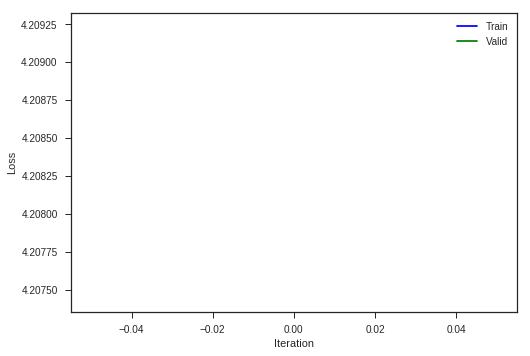

501: Training loss 1.802356. Validation loss 1.866645.
Gradient norm: 0.181845

    houulleve' in a wery your sisikal treatterr crave a taden, talk a tnovent'd and heop, the decey-nous veriny would freiced he proce, the venwed monsemedits orle rufn!, and to this taintiles that's siln and breed an wardery:
    What thick's 'taze be bandfiid, ve arworte, she with thou but the rivrided mest will antay: or jetoun,
    Wide, we then lave the taince and be hourse
    The vourt; be owe-rvore?
    
    QUEEN ELIZABETH:
    I pollery's peresed thee, heok is.
    Lenthert more of have shall have at age; con
    This yo



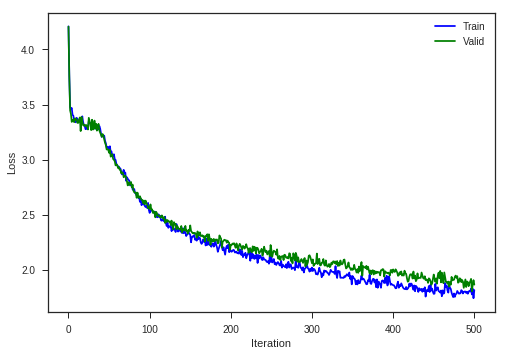

1001: Training loss 1.565987. Validation loss 1.803649.
Gradient norm: 0.172532

    kummon I.
    If admots to mont thee?
    But her he will insprakes our quar, King MutoniCOstey!
    
    MENENIUS:
    Why, the are bare once,
    Think, our knusester man kimy to know
    Hake truch it he way he rather's opesage thereforc,
    Net a fring fripon with kindering.
    
    DUKE OF AUMERLE:
    Beods mas he spue take thee,
    And for my courtion I, which.
    
    MEMHO:
    Will chilg of you did well, why, 'couses:
    Or Iffort enfy before dagchilecy have and
    Offortaus mone acts.
    And and in in you must you once;
    Unkinds faegh then I hath wi



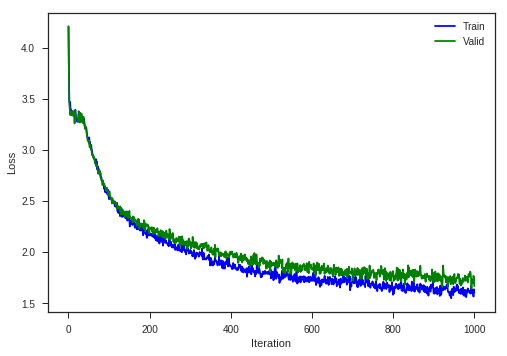

Reducing learning rate.
1501: Training loss 1.604043. Validation loss 1.622049.
Gradient norm: 0.195386

    sence cumily, I speak with Murders.
    
    VALERIZEO:
    My heasts the contentest.
    
    MMANERLA:
    For dark mering gain hear thou que: if my worth,
    So plucking; then my dined both'd to him the dead; and them a huss: but you shall here, but steal! Edward's heaven to my gaance,
    The sink to the hight: who see thelefarm to hers: bift of must. Let me, sway with me you well fear me,
    Of Camilloo spraped to vence out be: batter love,
    I had be powry will not God: you rest the fat
    Of the bound! but hences of hope had m



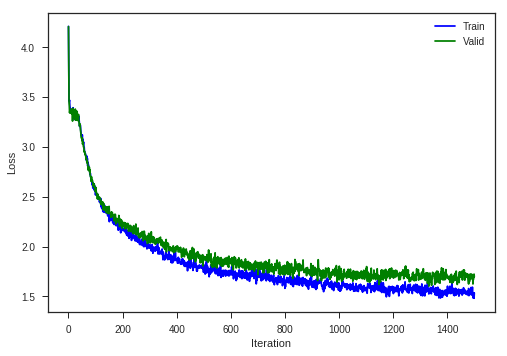

Test loss 1.841243


In [59]:
#@title Run experiment
NUM_TRAINING_ITERATIONS = 2000 #@param
REPORT_INTERVAL = 500 #@param
REDUCE_LEARNING_RATE_INTERVAL = 1500 #@param

DEPTH = 2 #@param
BATCH_SIZE = 64 #@param
NUM_HIDDEN = 128 #@param
TRUNCATION_LENGTH = 64 #@param Sequence size for training.
SAMPLE_LENGTH = 500 #@param Sequence size for sampling.
MAX_GRAD_NORM = None #@param Gradient clipping norm limit.
LEARNING_RATE = 0.01 #@param Optimizer learning rate.
REDUCE_LEARNING_RATE_MULTIPLIER = 0.1 #@param Learning rate is multiplied by this when reduced.
OPTIMIZER_EPSILON = 1e-8 #@param Adam epsilon

RNN_CORE = "snt.LSTM" #@param ['RNN', 'snt.LSTM', 'snt.GRU', 'ExposedLSTM']
RNN_CORE = eval(RNN_CORE)

TESTING_ITERATIONS = 1000 #@param


print("Building the graph")
print()

tf.reset_default_graph()

graph_tensors, dataset_train = build_graph(
    depth=DEPTH, 
    batch_size=BATCH_SIZE,
    num_hidden=NUM_HIDDEN,
    truncation_length=TRUNCATION_LENGTH,
    sample_length=SAMPLE_LENGTH,
    max_grad_norm=MAX_GRAD_NORM,
    initial_learning_rate=LEARNING_RATE,
    reduce_learning_rate_multiplier=REDUCE_LEARNING_RATE_MULTIPLIER,
    optimizer_epsilon=OPTIMIZER_EPSILON,
    rnn_core=RNN_CORE)

init = tf.global_variables_initializer()

# Train the network.
print("Training starts...")
print()

sess = tf.train.MonitoredSession()
sess.run(init)

train_losses = []
valid_losses = []

for train_iteration in range(NUM_TRAINING_ITERATIONS):
  if train_iteration % REPORT_INTERVAL == 1:
    train_loss_v, valid_loss_v, _, raw_gradients = sess.run(
        (graph_tensors["train_loss"],
         graph_tensors["valid_loss"],
         graph_tensors["train_step"],
         graph_tensors["raw_gradients"]))

    train_generated_string_v = sess.run(
        graph_tensors["train_generated_string"])

    train_generated_string_human = dataset_train.to_human_readable(
        (train_generated_string_v, 0), False, indices=[0], pretify=True)

    print("%d: Training loss %f. Validation loss %f." % (
                    train_iteration,
                    train_loss_v,
                    valid_loss_v))

    print("Gradient norm: %f" % np.linalg.norm(np.concatenate(
        [g.reshape(-1) for g in raw_gradients])))
    print()
    print(train_generated_string_human)
    print()
    

    plt.figure()
    plt.plot(train_losses, c='b', label='Train')
    plt.plot(valid_losses, c='g', label='Valid')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()
  else:
    train_loss_v, valid_loss_v, _ = sess.run((graph_tensors["train_loss"],
                                              graph_tensors["valid_loss"],
                                              graph_tensors["train_step"]))
    
  train_losses.append(train_loss_v)
  valid_losses.append(valid_loss_v)


  if (train_iteration + 1) % REDUCE_LEARNING_RATE_INTERVAL == 0:
    sess.run(graph_tensors["reduce_learning_rate"])
    print("Reducing learning rate.")

test_losses = []    
for k in range(TESTING_ITERATIONS):    
  test_loss_v = sess.run(graph_tensors["test_loss"])
  test_losses.append(test_loss_v)
  
print("Test loss %f" % np.mean(test_losses))


## Ex 3.1   Analysis of single neurons and gates

We will now look at the individual activations of neurons in a Recurrent network. For this to work, you need to have completed the previous exercise in which you expose the network activations, as well as train a model.

For a similar analysis, see [this paper](https://arxiv.org/pdf/1506.02078.pdf).

In [0]:
#@title String plot function

def string_plot(chars, values, title=None):
  """
  Given a string "chars" and a vector of numbers "values" of the same length
  displays the string, using "|" as EOL symbol, and colors each character
  background using corresponding value in values
  """
  
  assert len(chars) == len(values)
  
  lines = []
  line = ""
  for char in chars:
    if char != '|':
      line += char
    else:
      line += " "
      lines.append(line)
      line = ""
  lines.append(line)
  
  height = len(lines) 
  width = max(map(len, lines))
    
  data = np.zeros((height, width))
  data[:,:] = np.nan
  
  pos = 0
  for lid, line in enumerate(lines):
    data[lid, :len(line)] = values[pos: pos+len(line)]
    pos = pos+len(line)
    
  assert pos == len(values)
    
  plt.figure(figsize=(width * 0.3, height * 0.3))
  plt.title(title)
  plt.imshow(data.reshape((height, width)), interpolation='none',
             cmap='Reds', alpha=0.5)
  plt.axis('off')
  
  for lid, line in enumerate(lines):
    for cid, char in enumerate(line):
      plt.text(cid-0.2,lid+0.2,char,color='k',fontsize=9)

  plt.show()
  plt.close()

In [61]:
#@title Generate some new text and corresponding activations

text, activations = sess.run([
    graph_tensors['train_generated_string'],
    graph_tensors['activations']
])


print(dataset_train.to_human_readable((text, 0), False, indices=[0],
                                      pretify=True))

    t from the rage.
    
    QUEEN MARGARET:
    Stark of Cloudot pertark to this by tifes in Canicona, this life;
    Kith ofe! a thower when Rorsante with a spent?
    
    CORIOLANUS:
    O, please and yourself, what forms
    Of the mire compectaly uncle,
    And Citizen:
    I'll have tentery four than my lady.
    
    AUTOLYCUS:
    Chould the farnition Romeo not upon and too must,
    And consul the saw of Merus wrath
    With thern belt their ways more with thy subject such name, to your wind.
    
    HENRY BOLINGBROKE:
    Them well, villain, the begue
    and p


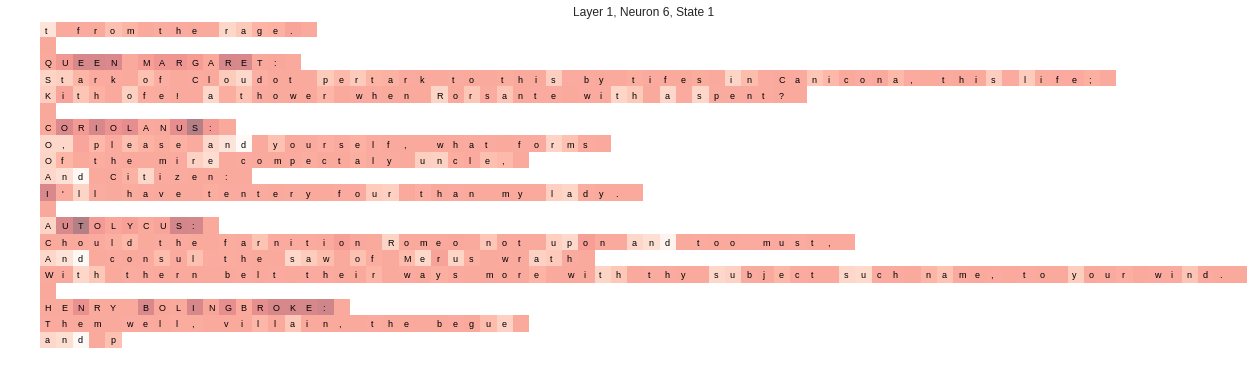

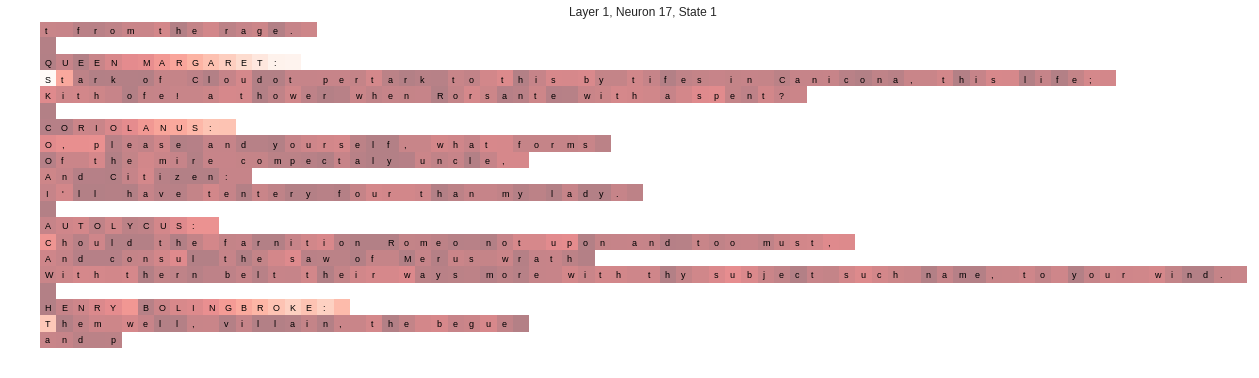

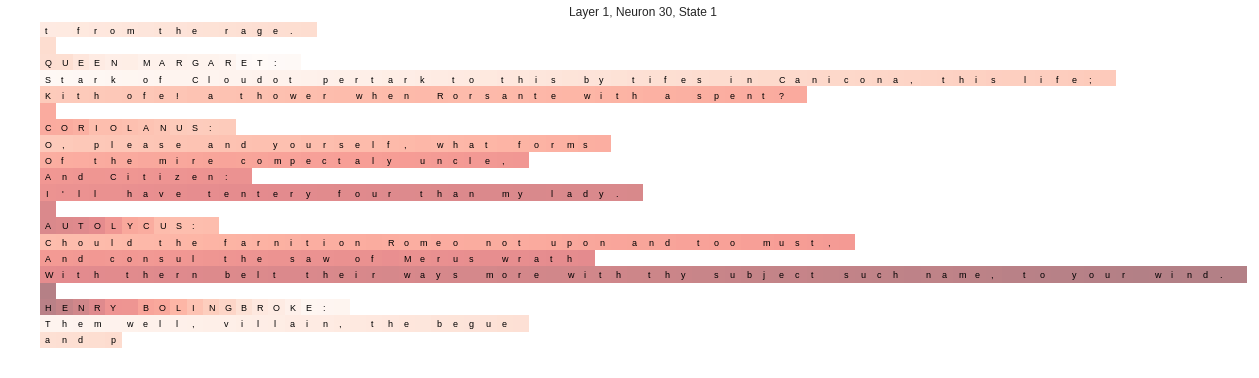

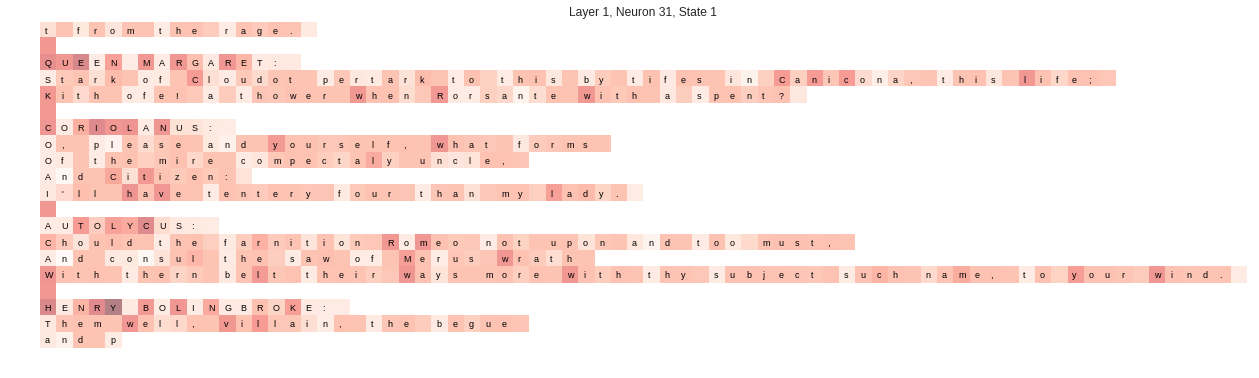

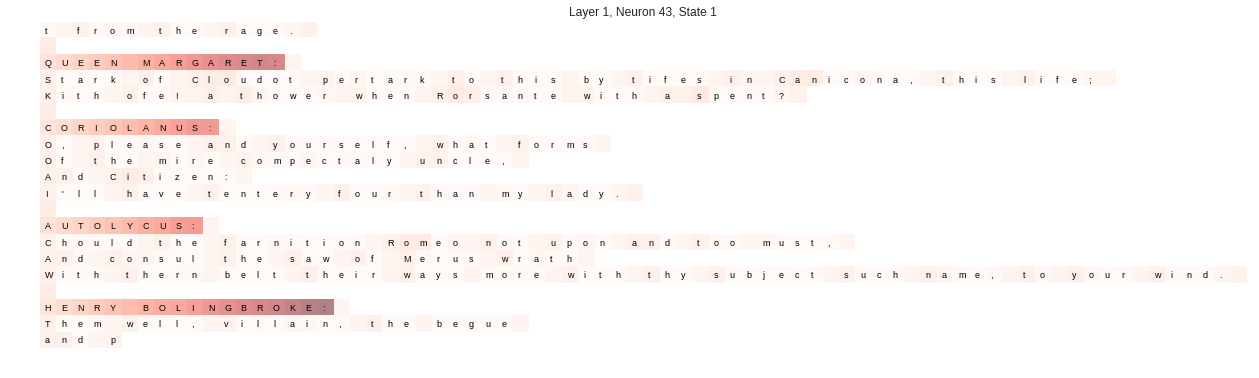

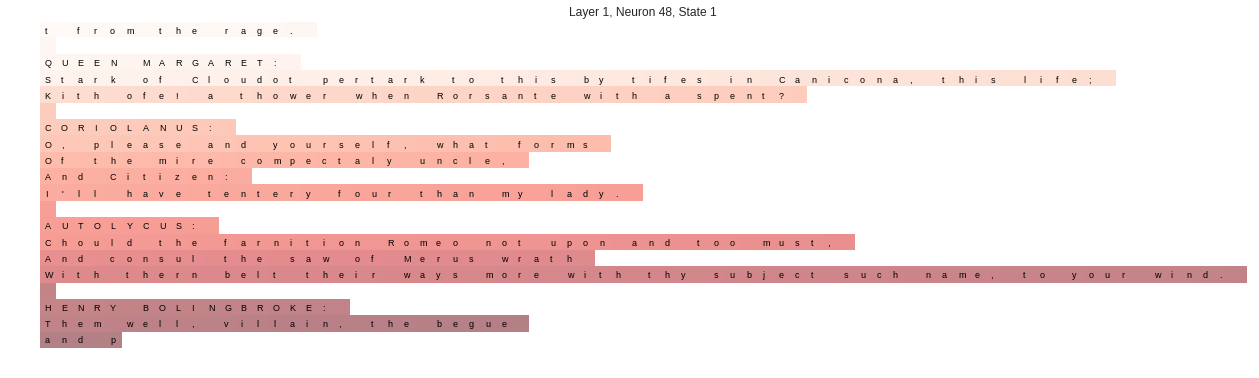

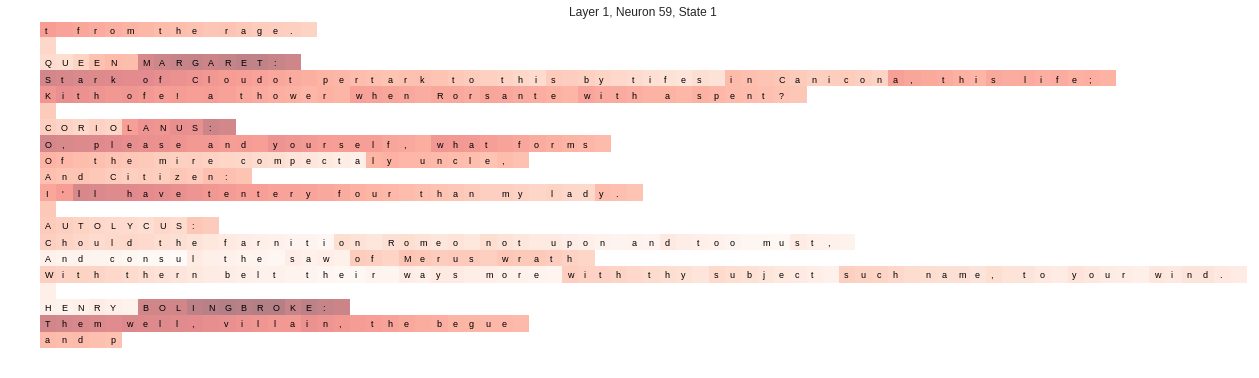

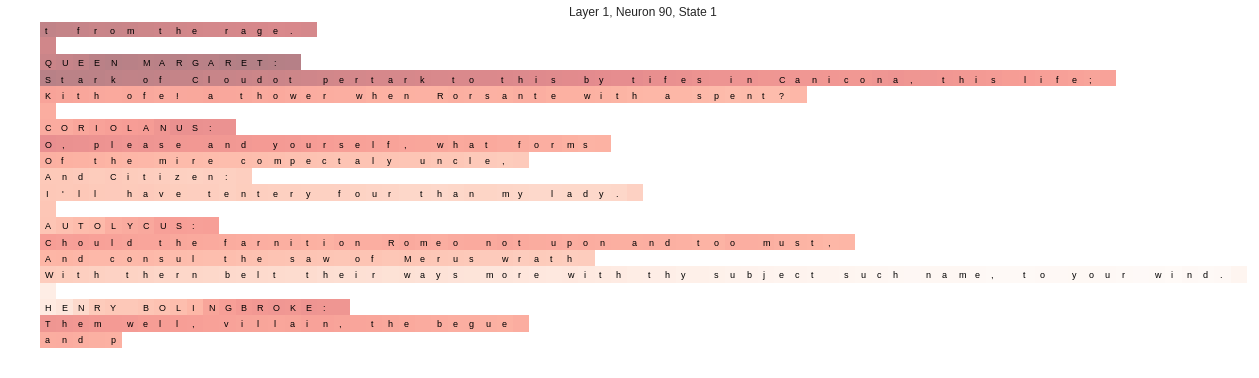

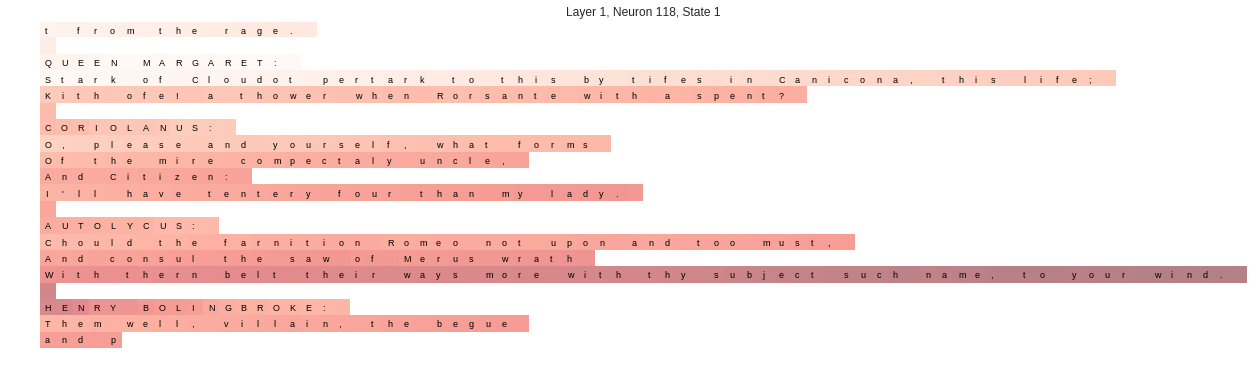

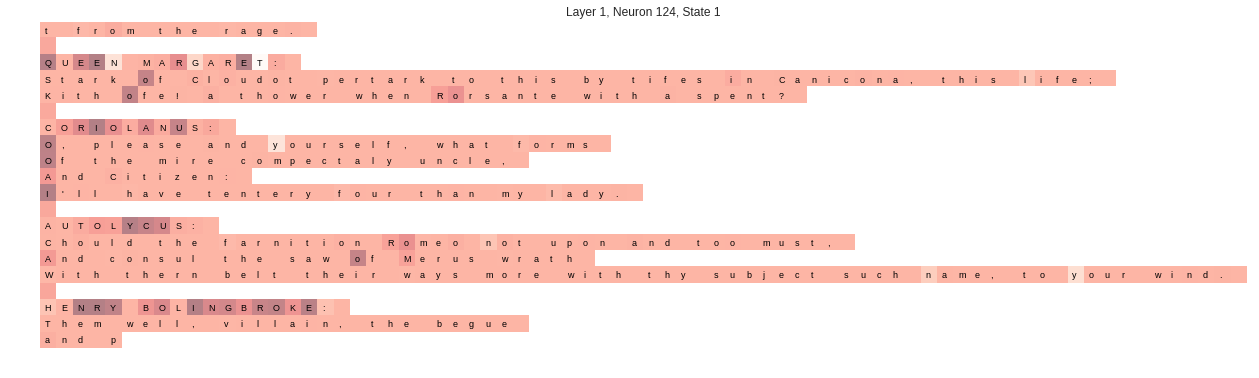

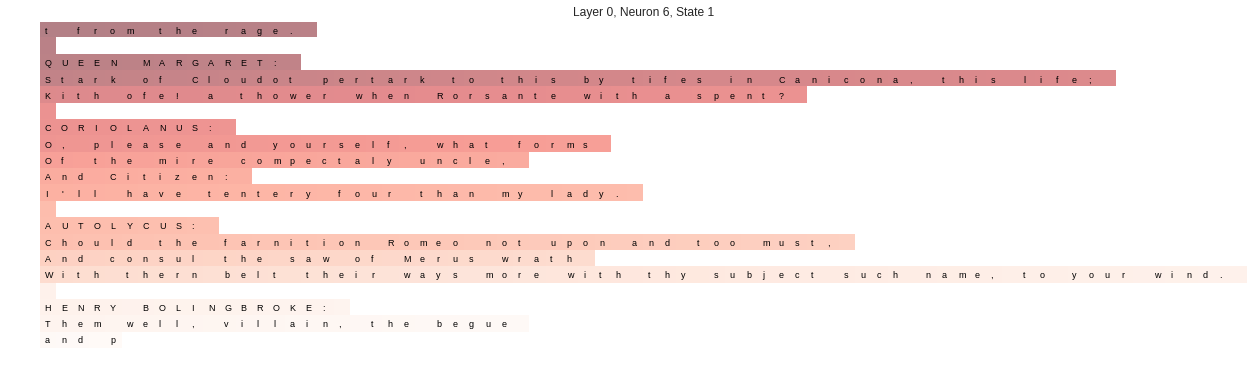

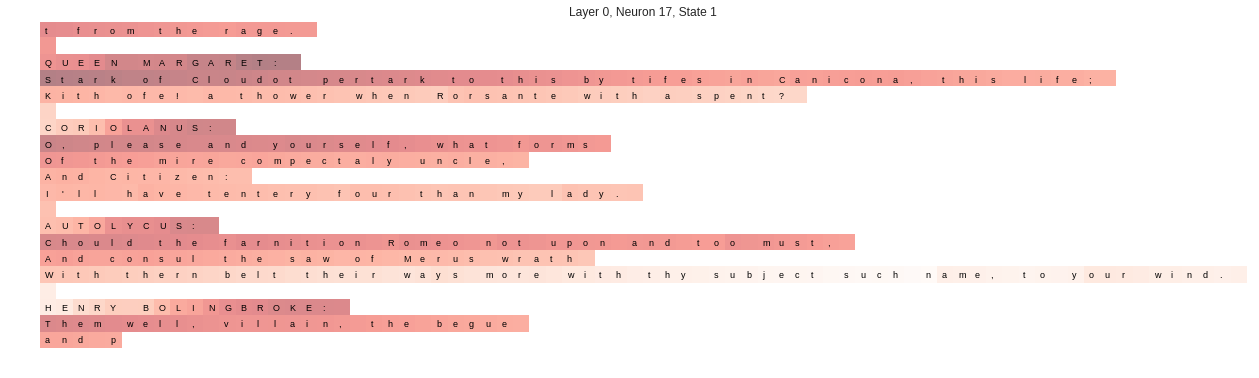

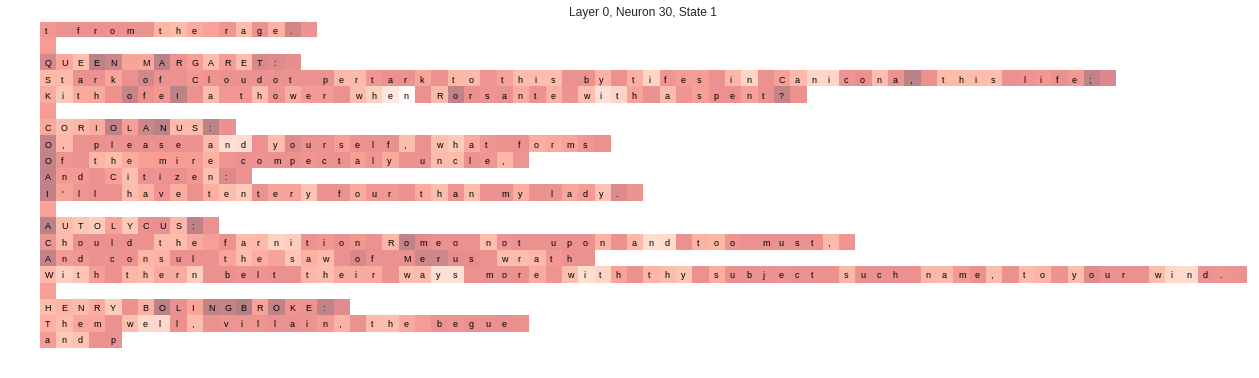

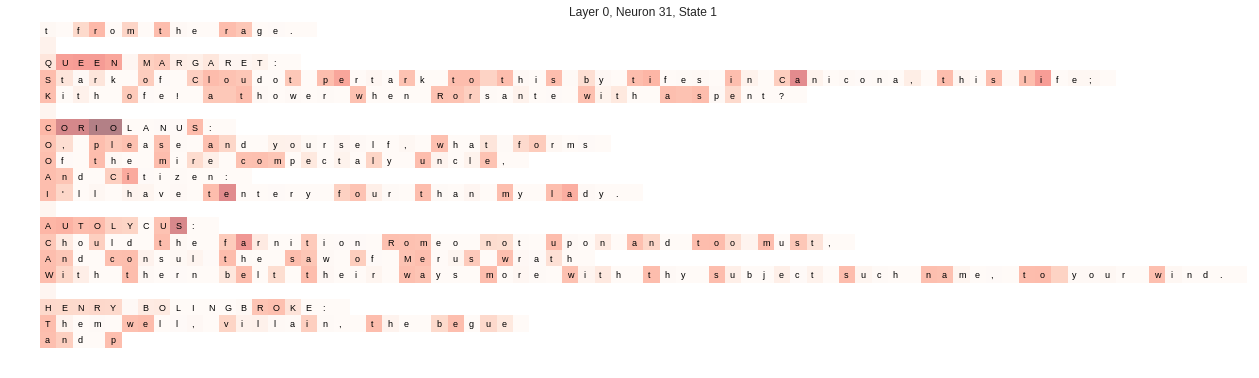

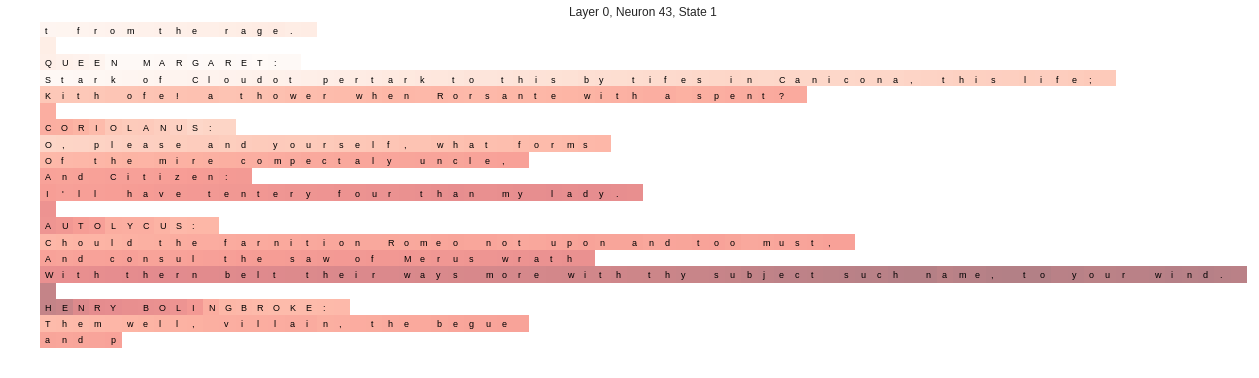

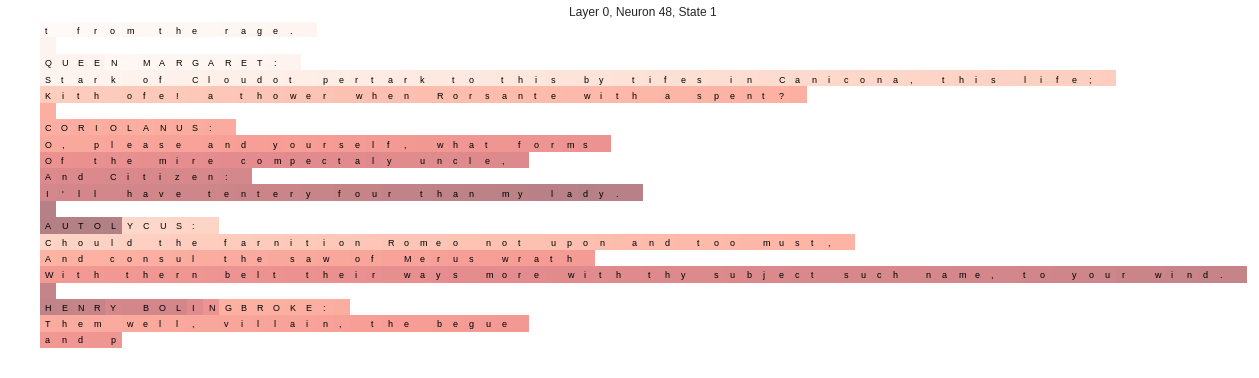

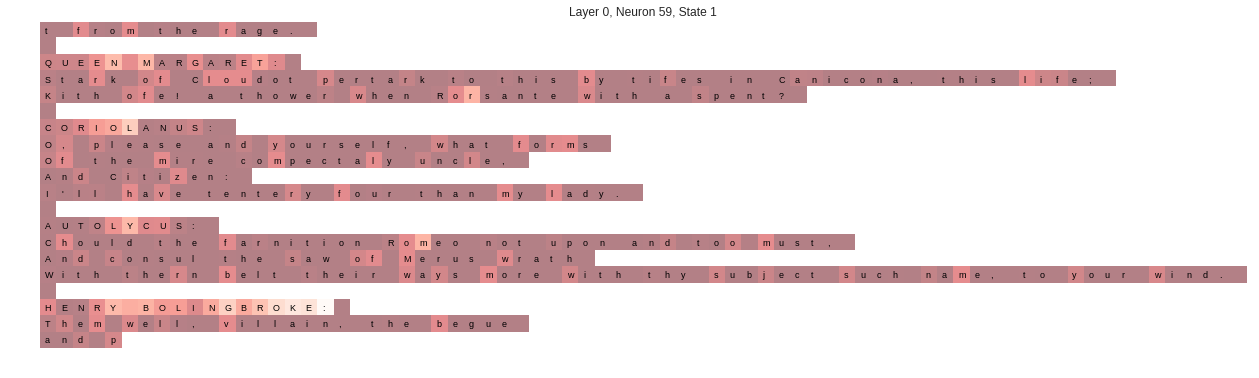

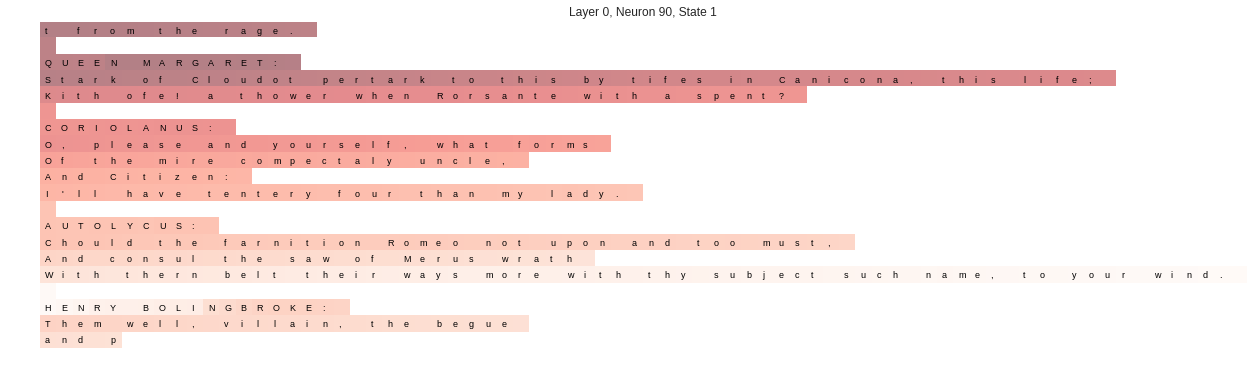

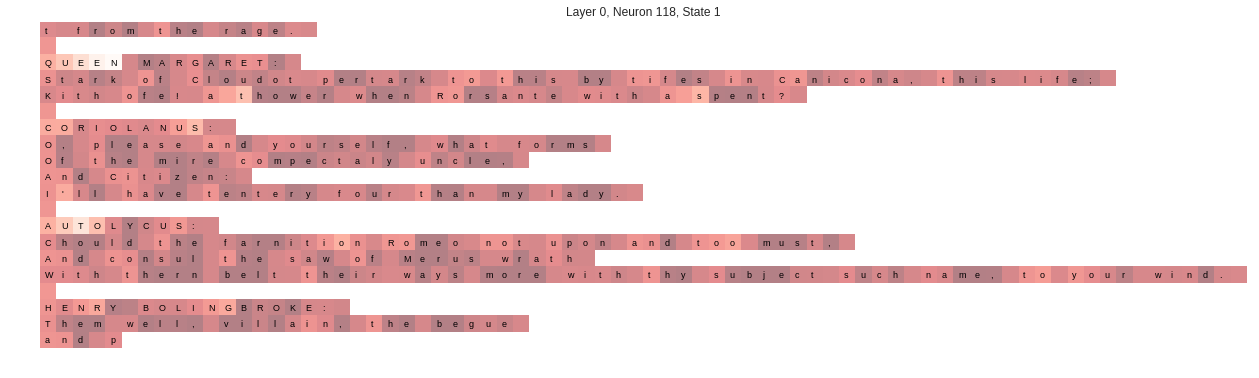

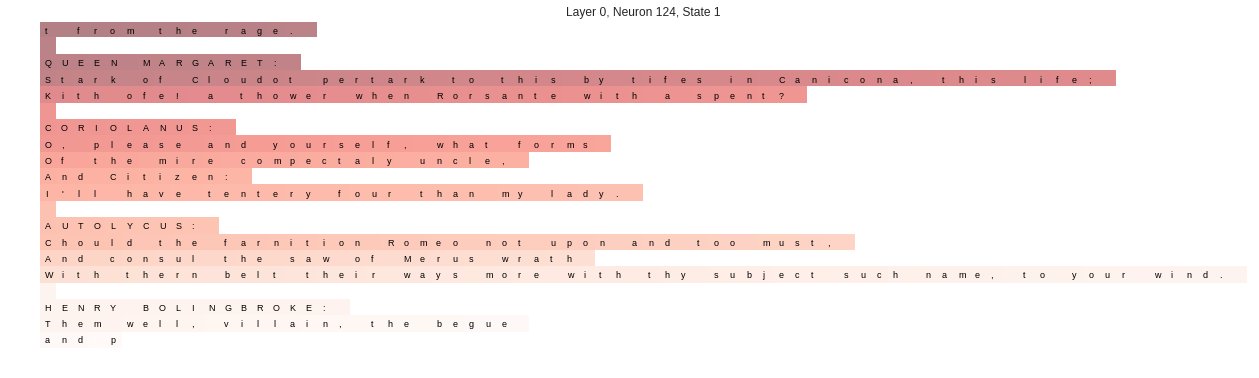

In [62]:
#@title Display activities of random neurons

NUMBER_OF_NEURONS = 10 #@param
STATE_DIM = 1 #@param 

if len(activations.shape) == 5:
  selected_activations = activations[:, :, STATE_DIM, 0, :]
else:
  selected_activations = activations[:, :, 0, :]

chars = list(dataset_train.to_human_readable(
        (text, 0), False, indices=[0]))

neurons_ids = np.random.choice(range(activations.shape[-1]), 
                               min(NUMBER_OF_NEURONS, activations.shape[-1]),
                               replace=False)

for layer_id in reversed(range(selected_activations.shape[1])): 
  values = selected_activations[:, layer_id, :].T
  for neuron in sorted(neurons_ids):
    string_plot(chars, 
                values[neuron],
                title='Layer %d, Neuron %d, State %d' 
                % (layer_id, neuron, STATE_DIM))



### What kind of neurons can we expect to find?

* Lots of counting neurons (their activity is just growing/decreasing independently from input)
* Names neuron - activates around names of people in the play, such as HAMLET: or JOHN OF GAUNT:
* Line width neuron - with activity proportional to the length of the current line (number of charaters since last "|")
* Paragraph length neuron - activity proportional to the length of the paragraph in lines
* Special character neurons - such as coding for probability of generating ":"
* Many, many mixtures of the above

Note, that if neurons like these do not appear it does not mean that network does not "know" these elements. Highly discriminative, single neuron decoupling is not something neural networks are trained to do, it is just an empirical observation, shared across many domains (cat neurons in visual classifiers etc.). Knowledge can be represented in many other ways, in particular the fact that it is represented in a single neuron does not mean network does not have a distributed "backup" of the same knowledge somewhere else.


## Ex 3.2   Analysis of the state dynamics

In this exercise, we will visualize the activations in a different way, by projecting them to 2 dimensions, via dimensionality reduction. 

When using different projection techniques, you willl see different results. For example, PCA will display the directions with most variance in the data.

In [0]:
#@title Compute 2D projection of the hidden state

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

projector = 'PCA' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 5},
    'PCA': {},
    'Isomap': {}
}

values = selected_activations.reshape(selected_activations.shape[0], -1)
projector = projector_fun(n_components=2, **kwargs[projector])

values_2d = projector.fit_transform(values)


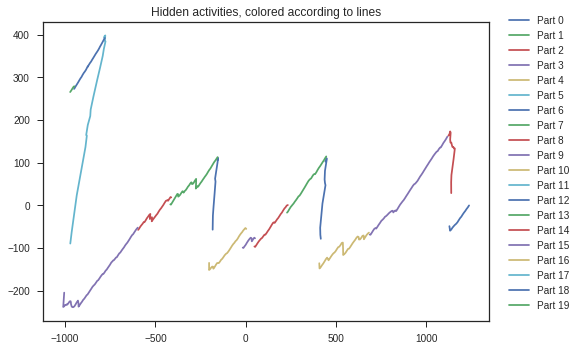

Part 0
    t from the rage.
    

Part 1
    
    

Part 2
    QUEEN MARGARET:
    

Part 3
    Stark of Cloudot pertark to this by tifes in Canicona, this life;
    

Part 4
    Kith ofe! a thower when Rorsante with a spent?
    

Part 5
    
    

Part 6
    CORIOLANUS:
    

Part 7
    O, please and yourself, what forms
    

Part 8
    Of the mire compectaly uncle,
    

Part 9
    And Citizen:
    

Part 10
    I'll have tentery four than my lady.
    

Part 11
    
    

Part 12
    AUTOLYCUS:
    

Part 13
    Chould the farnition Romeo not upon and too must,
    

Part 14
    And consul the saw of Merus wrath
    

Part 15
    With thern belt their ways more with thy subject such name, to your wind.
    

Part 16
    
    

Part 17
    HENRY BOLINGBROKE:
    

Part 18
    Them well, villain, the begue
    

Part 19
    and p



In [64]:
#@title Data plotter

splits = {
    'nothing': ('$', ),
    'lines': ('|', ),
    'paragraphs': ('|', '|', ),
}

split_criterion = 'lines' #@param ['nothing', 'lines', 'paragraphs']

parts = []
part = ""
for cid, char in enumerate(chars):
  match = True
  part += char
  for k in range(min(len(chars)-cid, len(splits[split_criterion]))):
    if chars[cid+k] != splits[split_criterion][k]:
      match = False
  if match:
    parts.append(len(part))
    part = ""
    
if len(part)>0:    
  parts.append(len(part))    
  

plt.figure()
plt.title('Hidden activities, colored according to %s' 
          % split_criterion.replace('_', ' '))
current = 0
for part_id, part in enumerate(parts):
  plt.plot(values_2d[current:current+part,0],
           values_2d[current:current+part,1],
           label='Part %d' % part_id)
  current += part
  
plt.legend(bbox_to_anchor=(1.2, 1.05))  
plt.show()

current = 0
for part_id, part in enumerate(parts):
  print('Part %d' % part_id)
  print(dataset_train.to_human_readable((text[current:current+part], 0),
                                              False, indices=[0],
                                              pretify=True))
  print()
  
  current += part
  

### So what am I looking at?

2D projections of high-dimensional spaces are always loosing a lot of information, however the general structure can still be recovered. Here, one can see that both paragraph-splits and line-splits can be decoded by just looking at the dynamics of the hidden state, giving more insights into internals of an RNN. Note, that contrary to single-neuron analysis, here we are truly looking at the whole picture, thus what is observed is likely behind the dynamics of this model.

## Ex 3.3   One step further (Optional)


Now how about gates? Can we expose elements of our RNN to be able to visualise them too?

This exercise entails implementing an LSTM core - including the gates. 

$$
f_t = \sigma_s( W_f x_t + U_f h_{t-1} + b_f )
$$
$$
i_t = \sigma_s( W_i x_t + U_i h_{t-1} + b_i )
$$
$$
o_t = \sigma_s( W_o x_t + U_o h_{t-1} + b_o )
$$
$$
c_t = f_t \odot c_{t-1} + i_t \odot \sigma_c( W_c x_t + U_c h_{t-1} + b_c )
$$
$$
h_t = o_t \odot \sigma_h(c_t) 
$$

where
$$
\sigma_s \text{ is sigmoid}
$$
$$
\sigma_c  \text{ and } \sigma_h \text{ are tanh}
$$

and your task is to expose $f_t$ and $i_t$ rather than just $h_t$ and $c_t$.

In [0]:
#@title Custom LSTM implementation, exposing its internals - Starting point

import collections
from tensorflow.python.ops import array_ops


ExposedLSTMState = collections.namedtuple("ExposedLSTMState",
                                          ("hidden", "cell", 
                                           "forget_gate", "input_gate",
                                           ))


class ExposedLSTM(snt.LSTM):
  
  def __init__(self, *args, **kwargs):
    super(ExposedLSTM, self).__init__(*args, **kwargs)
  
  def _build(self, inputs, prev_state):

    ################
    #   YOUR CODE  #
    ################
    
    return next_hidden, ExposedLSTMState(hidden=next_hidden,
                                         cell=next_cell,
                                         forget_gate=forget_mask,
                                         input_gate=input_mask)

  @property
  def state_size(self):
    """Tuple of `tf.TensorShape`s indicating the size of state tensors."""
    return ExposedLSTMState(tf.TensorShape([self._hidden_state_size]),
                            tf.TensorShape([self._hidden_size]),
                            tf.TensorShape([self._hidden_size]),
                            tf.TensorShape([self._hidden_size]),
                            )

###What kind of neuron-gate interactions we can expect?

This should further support previous findings - showing how gates are used to support specific neuronal functions. For example, can you find:

* A "lets start from scratch as this is a new line" interaction?
* A "lets start from scratch as this is a new paragraph" interaction?

The search for these interpretable internals can be exhaustive, but they will emerge in nearly every run. 